In [1]:
import wrds 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import quandl
import copy
import numpy as np
import seaborn as sns

In [2]:
# WRDS Connection 
db = wrds.Connection(wrds_username='riccardoalberti')

Enter your WRDS username [riccardo]: riccardoalberti
Enter your password: ·······················


WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [6]:
start = '2011-01-26' # inception date XTL ETF
end = dt.datetime(2021,6,30)

### What to import:
#### - Interest rates US
#### - Indices S&P, NASDAQ
#### - XTL ETF
#### - Amount of monthly MBS bought by FED
#### - Amount of monthly Treasuries bought by FED
#### - Consumer Price Index

In [8]:
# Import data from WRDS
Interest_Rates_US = db.raw_sql('select * from frb.rates_monthly')
Interest_Rates_fx = db.raw_sql('select * from frb.fx_monthly')
Fama_French_5_factors = db.raw_sql('select * from ff.factors_monthly', date_cols=['date'])

# Import Indices
sp500 = db.get_table(library='crsp', table='msp500') 
nasdaq = yf.download('QQQ', start='2003-01-01',end=end, interval='1mo')
nasdaq = nasdaq.dropna(axis=0)

# Import ETF data
XTL_daily = yf.download('XTL', start, end, interval='1d') ### the real ticker is XLF Financial Select Sector SPDR Fund
XTL_weekly = yf.download('XTL', start, end, interval='1wk')
XTL_monthly = yf.download('XTL', start, end='2020-05-30', interval='1mo')

# Import MBS held by FED from: https://fred.stlouisfed.org/series/WSHOMCB#0
Daily_WSHOMCB = pd.read_excel('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Tapering/WSHOMCB.xls', sheet_name='Daily_Data')
Monthly_WSHOMCB = pd.read_excel('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Tapering/WSHOMCB.xls', sheet_name='Monthly_Data')
Monthly_Bills_FED = pd.read_excel('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Tapering/TREAST.xls', sheet_name='Data')

# Import CPI from Quandl from: https://www.quandl.com/data/RATEINF/CPI_USA-Consumer-Price-Index-USA
CPI = quandl.get("RATEINF/CPI_USA", end_date='2021-06-30',authtoken="DcKQHEuXK66-wnpAjQ1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### How has Quantitative Easing evolved?

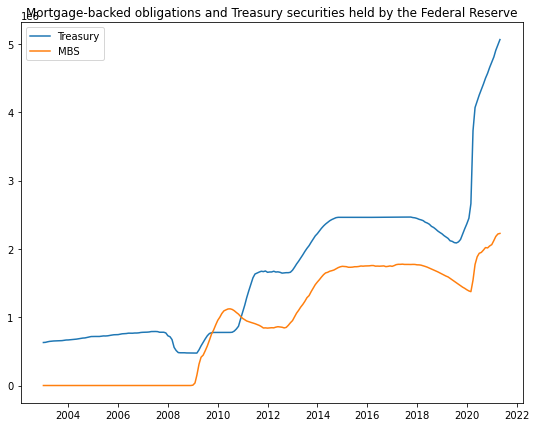

In [9]:
plt.figure(figsize=(9,7))
plt.title('Mortgage-backed obligations and Treasury securities held by the Federal Reserve')
plt.plot(Monthly_Bills_FED.set_index('DATE'), label='Treasury')
plt.plot(Monthly_WSHOMCB.set_index('DATE'), label='MBS')
plt.legend()
plt.savefig('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Tapering/Assets FED+Total')

### When did Tapering begin?
#### To understand, plot total securities held, monthly purchase differences, and % change

In [10]:
# concatenate purchases of MBS and Trasuries in a single dataframe
QE_df = pd.concat([Monthly_Bills_FED.set_index('DATE'),Monthly_WSHOMCB.set_index('DATE')], axis=1)
QE_df['Delta1mo_TREAST'] = (QE_df.shift(-1)-QE_df).TREAST
QE_df['Delta1mo_WSHOMCB'] = (QE_df.shift(-1)-QE_df).WSHOMCB

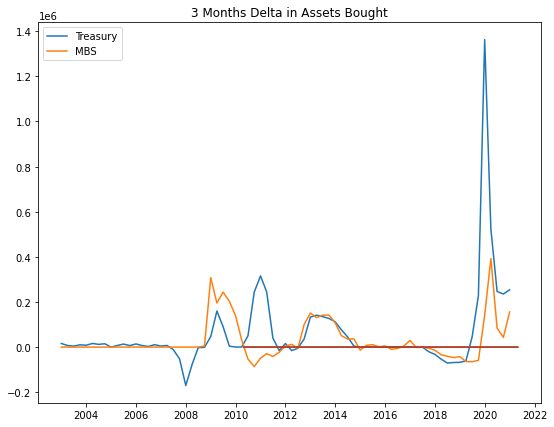

In [15]:
plt.figure(figsize=(9,7))
plt.title('3 Months Delta in Assets Bought')
plt.plot((QE_df[QE_df.columns[:2]][::3].shift(-1)-QE_df[QE_df.columns[:2]][::3]).TREAST, label='Treasury')
plt.plot((QE_df[QE_df.columns[:2]][::3].shift(-1)-QE_df[QE_df.columns[:2]][::3]).WSHOMCB, label='MBS')
plt.legend()
#plt.savefig('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Tapering/Delta in Assets Bought')

In [17]:
def normalise_data(df):
    df_normalised = (df - np.min(df)) / (np.max(df) - np.min(df))
    return df_normalised

In [22]:
normalised_CPI = normalise_data(CPI)
normalised_QE = normalise_data(QE_df)
CPI_QE_norm = pd.concat([normalised_CPI.loc['2003':'2021-05-31'], pd.DataFrame(normalised_QE.loc['2003-02':]).set_index(normalised_CPI.loc['2003':'2021-05-31'].index)], axis=1)

#### Correlations between absolute values

In [84]:
CPI_QE_norm.corr()

,Value,TREAST,WSHOMCB,Delta1mo_TREAST,Delta1mo_WSHOMCB
Value,1.000000,0.855957,0.911929,0.224395,0.091991
TREAST,0.855957,1.000000,0.876390,0.239530,0.136533
WSHOMCB,0.911929,0.876390,1.000000,0.151833,0.048005
Delta1mo_TREAST,0.224395,0.239530,0.151833,1.000000,0.496565
Delta1mo_WSHOMCB,0.091991,0.136533,0.048005,0.496565,1.000000


#### Correlation between % changes

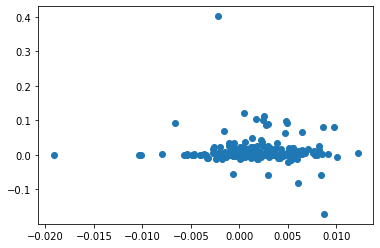

In [52]:
plt.scatter(CPI.pct_change().loc['2003':'2021-05-31'], QE_df[1:].pct_change()['TREAST'])

In [83]:
(pd.DataFrame([QE_df[1:].pct_change()['TREAST'].values,(CPI.pct_change().loc['2003':'2021-05-31']).reset_index()['Value']]).T).corr()

,0,1
0,1.000000,-0.051873
1,-0.051873,1.000000


### Sensitivity of Sectors to QE/Tapering
#### Start with S&P

In [85]:
import statsmodels.api as sm
from statsmodels import regression

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    x = x[:,1]
    return model.params[0], model.params[1], model.rsquared, #model.summary()

In [88]:
sp = sp500
sp.caldt = pd.to_datetime(sp.caldt)
sp = sp500.set_index('caldt')

In [198]:
sp_returns = sp.loc['2003-02':'2021-04-30']['sprtrn'] # sprtn=Return on the S&P 500 Index
sp_returns = sp_returns.values

sp_level = sp.loc['2003-02':'2021-04-30']['spindx']
sp_level = sp_level.values

X = QE_df.TREAST[2:].loc[:'2021-05-01']
X = X.values

Regression results for TREAST absolute levels vs SP absolute levels are:  (711.9218135914762, 0.0006316373844899696, 0.7949765298027306) and correlation:  0.891614563476131


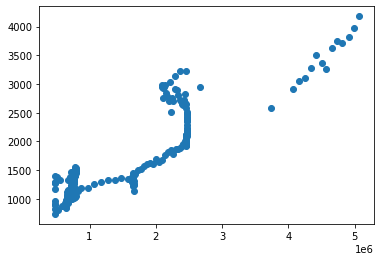

Regression results for TREAST % changes vs SP returns are:  (0.008211387756397527, 0.0026446490353910007, 6.252597882228095e-06) and correlation:  0.002500519522540591


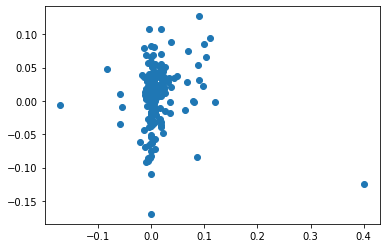

In [238]:
print('Regression results for TREAST absolute levels vs SP absolute levels are: ', linreg(x=X,y=sp_level), 'and correlation: ', np.corrcoef(X,sp_level)[1][0])
plt.scatter(x=X,y=sp_level)
plt.show()

print('Regression results for TREAST % changes vs SP returns are: ', 
      linreg(x=QE_df.TREAST[2:].loc[:'2021-05-01'].pct_change()[1:].values,y=sp_returns[1:]), 
      'and correlation: ', 
      np.corrcoef(QE_df.TREAST[2:].loc[:'2021-05-01'].pct_change()[1:], sp_returns[1:])[1][0])
plt.scatter(x=QE_df.TREAST[2:].loc[:'2021-05-01'].pct_change()[1:],y=sp_returns[1:])
plt.show()

#### Function that tells you whether there was a QE phase during a period of months n

In [247]:
def QE_phase(data, column, interval1 ,interval2, threshold):
    plt.plot(data[column].loc[interval1:interval2].shift(-1)-data[column].loc[interval1:interval2])
    plt.title('Did month n+1 have more puchase than month n?')
    series = data[column].loc[interval1:interval2].shift(-1)-data[column].loc[interval1:interval2]<threshold
    return series[series==False]

In [242]:
QE_pct_change_df = QE_df.pct_change()

In [264]:
(QE_pct_change_df['TREAST']>=QE_pct_change_df['TREAST'].shift()).value_counts()

False    125
True      97
Name: TREAST, dtype: int64

In [291]:
a=(QE_pct_change_df['TREAST']>=QE_pct_change_df['TREAST'].shift())

In [293]:
b = (QE_pct_change_df['TREAST']>=QE_pct_change_df['TREAST'].shift()).cumsum()

In [302]:
c = b.sub(b.mask(a).ffill().fillna(0)).astype(int)

<AxesSubplot:xlabel='DATE'>

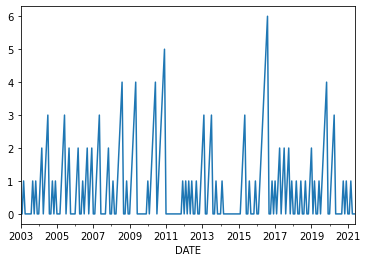

In [316]:
c.plot()

#### Indexes (i.e., dates) corresposponding to a phase of increase in % expense in TREAST opf at least three months (signaling increase in policy decision).

In [504]:
reference_indexes = c[c>=3].index

locs_reference_indexes = []
for index in range(0,len(reference_indexes)): 
    locs_reference_indexes.append(QE_df.index.get_loc(reference_indexes[index])) # it appends the index number corresponding to the last increase in % change.
    
def prova(x, z):
    return (QE_df['TREAST'].index[x - (c[c>=3][z]-1)]).strftime('%Y-%m-%d')

mapping = map(prova, locs_reference_indexes, range(0,len(reference_indexes)))

print('length: ', c[c>=3].values)
set(mapping)

length:  [3 3 3 3 4 3 4 3 4 3 4 5 3 3 3 3 4 5 6 3 4 3]


{'2004-05-01',
 '2005-04-01',
 '2007-03-01',
 '2008-05-01',
 '2009-02-01',
 '2010-03-01',
 '2010-08-01',
 '2012-12-01',
 '2013-05-01',
 '2015-03-01',
 '2016-03-01',
 '2019-08-01',
 '2020-02-01'}

In [507]:
# interesting that 10/13 are in the first 5 months of the year.

In [508]:
locs_reference_indexes

[18,
 29,
 52,
 66,
 67,
 75,
 76,
 88,
 89,
 93,
 94,
 95,
 121,
 126,
 148,
 160,
 161,
 162,
 163,
 201,
 202,
 207]

<AxesSubplot:xlabel='DATE'>

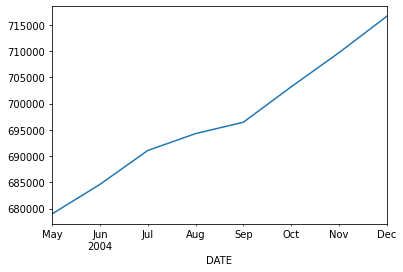

In [515]:
QE_df['TREAST'][16:24].plot()

In [533]:
(QE_pct_change_df['TREAST']*100)

DATE
2003-01-01         NaN
2003-02-01    0.396525
2003-03-01    1.148359
2003-04-01    0.991984
2003-05-01    0.584688
                ...   
2021-02-01    1.620430
2021-03-01    2.004160
2021-04-01    1.642794
2021-05-01    1.534977
2021-06-01    0.000000
Name: TREAST, Length: 222, dtype: float64

<AxesSubplot:xlabel='DATE'>

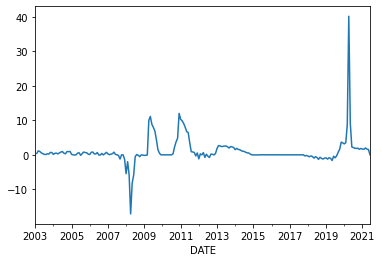

In [544]:
(QE_df.pct_change()*100)['TREAST'].plot()

In [547]:
QE_pct_change_df[QE_pct_change_df['TREAST']>=0.05]

,TREAST,WSHOMCB,Delta1mo_TREAST,Delta1mo_WSHOMCB
DATE,,,,
2009-04-01,0.100046,1.047711,0.223499,-0.364854
2009-05-01,0.111273,0.324973,-0.115317,-0.700084
2009-06-01,0.088585,0.073560,-0.023081,1.080496
2009-07-01,0.079498,0.142554,-0.065647,0.129911
2009-08-01,0.068809,0.140977,-0.313209,0.183795
2010-12-01,0.120020,-0.032168,-0.037821,-0.150055
2011-01-01,0.103106,-0.028250,0.053004,-0.275920
2011-02-01,0.098423,-0.021050,0.014579,-0.172784
2011-03-01,0.090910,-0.017787,-0.038200,-0.359523


In [550]:
QE_df.index.get_loc('2009-04-01')

75

<AxesSubplot:xlabel='DATE'>

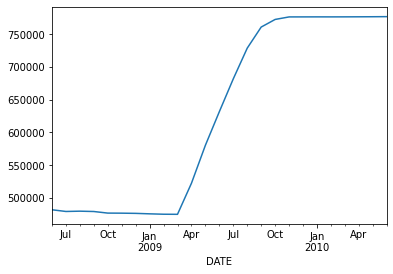

In [555]:
QE_df['TREAST'][65:90].plot()

<AxesSubplot:xlabel='caldt'>

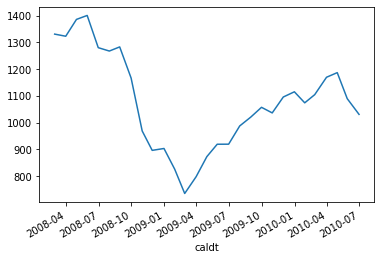

In [564]:
sp.loc['2008-02':'2010-06']['spindx'].plot()

In [565]:
QE_df.index.get_loc('2010-12-01')

95

<AxesSubplot:xlabel='DATE'>

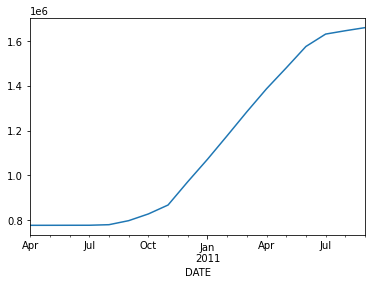

In [569]:
QE_df['TREAST'][87:105].plot()

<AxesSubplot:xlabel='caldt'>

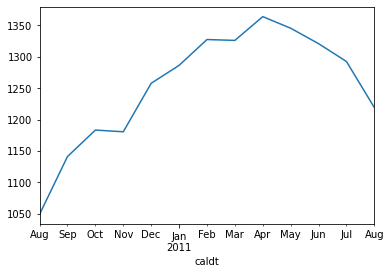

In [570]:
sp.loc['2010-08':'2011-08']['spindx'].plot()

In [571]:
QE_df.index.get_loc('2020-03-01')

206

<AxesSubplot:xlabel='DATE'>

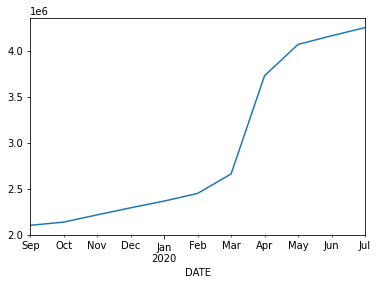

In [572]:
QE_df['TREAST'][200:211].plot()

<AxesSubplot:xlabel='caldt'>

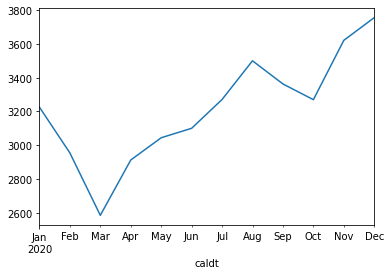

In [573]:
sp.loc['2020-01':'2020-12']['spindx'].plot()

In [577]:
QE_pct_change_df[QE_pct_change_df['TREAST']<-0.01]

,TREAST,WSHOMCB,Delta1mo_TREAST,Delta1mo_WSHOMCB
DATE,,,,
2007-09-01,-0.011988,NaN,-0.995782,NaN
2007-12-01,-0.012761,NaN,3.216217,NaN
2008-01-01,-0.054500,NaN,-0.656978,NaN
2008-02-01,-0.019772,NaN,1.846676,NaN
2008-03-01,-0.057421,NaN,1.805887,NaN
2008-04-01,-0.170932,NaN,-0.600760,NaN
2008-05-01,-0.082313,NaN,-0.347394,NaN
2008-06-01,-0.058536,NaN,-0.913210,NaN
2012-01-01,-0.011564,-0.003877,-1.250306,-1.755352


In [578]:
QE_df.index.get_loc('2008-01-01')

60

<AxesSubplot:xlabel='DATE'>

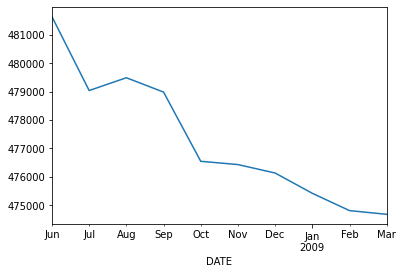

In [585]:
QE_df['TREAST'][65:75].plot()

<AxesSubplot:xlabel='caldt'>

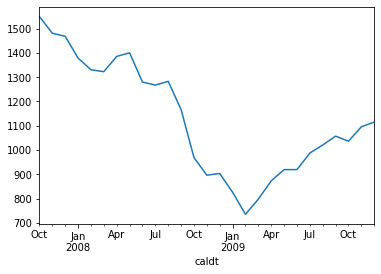

In [595]:
sp.loc['2007-10':'2009-12']['spindx'].plot()

In [588]:
QE_df.index.get_loc('2018-08-01')

187

<AxesSubplot:xlabel='DATE'>

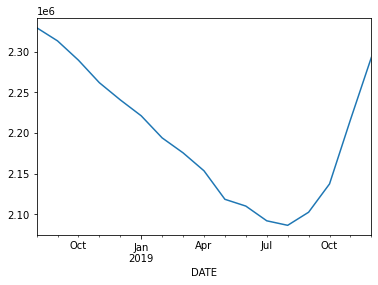

In [593]:
QE_df['TREAST'][187:204].plot()

<AxesSubplot:xlabel='caldt'>

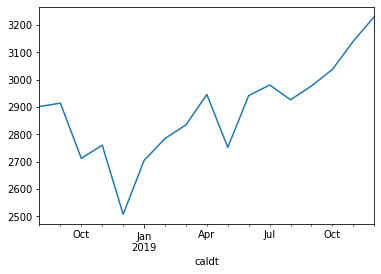

In [594]:
sp.loc['2018-08':'2019-12']['spindx'].plot()